# Gaussian and Bilateral filters with AVX

# Table of Contents
 <p><div class="lev1"><a href="#Gaussian-and-Bilateral-filters-with-AVX">Gaussian and Bilateral filters with AVX</a></div><div class="lev1"><a href="#1.-Introduction---theory">1. Introduction - theory</a></div><div class="lev1"><a href="#2.-Preprocessing-of-the-image">2. Preprocessing of the image</a></div><div class="lev2"><a href="#2.1-Kernel-truncation">2.1 Kernel truncation</a></div><div class="lev2"><a href="#2.2-Image-padding">2.2 Image padding</a></div><div class="lev1"><a href="#3.-Bilateral-filter">3. Bilateral filter</a></div><div class="lev1"><a href="#3.1-Code-implementations-and-optimization">3.1 Code implementations and optimization</a></div><div class="lev2"><a href="#3.1.1-Introductory-remarks">3.1.1 Introductory remarks</a></div><div class="lev2"><a href="#3.1.2-Cython,-AVX-and-Python-multithreading">3.1.2 Cython, AVX and Python multithreading</a></div><div class="lev3"><a href="#Cython">Cython</a></div><div class="lev3"><a href="#AVX">AVX</a></div><div class="lev3"><a href="#Python-multithreading">Python multithreading</a></div><div class="lev2"><a href="#Overview-of-the-optimizations-we-have-done">Overview of the optimizations we have done</a></div><div class="lev3"><a href="#Loop-over-the-pixels-of-the-output">Loop over the pixels of the output</a></div><div class="lev3"><a href="#Computation-for-one-pixel">Computation for one pixel</a></div><div class="lev2"><a href="#Our-implementations">Our implementations</a></div><div class="lev3"><a href="#r_r1">r_r1</a></div><div class="lev3"><a href="#r_pr1">r_pr1</a></div><div class="lev3"><a href="#r_AVX1">r_AVX1</a></div><div class="lev3"><a href="#r_r2">r_r2</a></div><div class="lev3"><a href="#r_pr2">r_pr2</a></div><div class="lev3"><a href="#r_AVX2">r_AVX2</a></div><div class="lev3"><a href="#prj_r1">prj_r1</a></div><div class="lev3"><a href="#prj_AVX">prj_AVX</a></div><div class="lev3"><a href="#step_r1">step_r1</a></div><div class="lev3"><a href="#AVX_r">AVX_r</a></div><div class="lev3"><a href="#mth_pr">mth_pr</a></div><div class="lev1"><a href="#Benchmarking-performances">Benchmarking performances</a></div><div class="lev2"><a href="#Benchmark-when-we-vary-the-size-of-the-image"><strong>Benchmark when we vary the size of the image</strong></a></div><div class="lev2"><a href="#Benchmark-when-we-vary-the-truncation-parameter"><strong>Benchmark when we vary the truncation parameter</strong></a></div><div class="lev2"><a href="#Benchmark-when-we-vary-the-truncation-parameter"><strong>Benchmark when we vary the truncation parameter</strong></a></div><div class="lev1"><a href="#4.-Gaussian-filter">4. Gaussian filter</a></div><div class="lev2"><a href="#4.1-Analysis">4.1 Analysis</a></div><div class="lev1"><a href="#Conclusion">Conclusion</a></div>

---

---

---

# 1. Introduction - theory

The Gaussian and the bilateral filters are two techniques used to blur images. The bilateral filter has the advantages of respecting strong edges. We present here the results of our home-made Gaussian and Bilateral filters (cf. figure below). Although the goal of this project is to improve the performance of the filter algorithms, we show here the actual images to give a qualitative insight.
![](test_bilateral.png)

Bluring is the simplest way of smoothing an image. In this project the **Gaussian filter** is defined as 

$$ C_{i,j} = \sum_{m=0}^{2 l_w} \sum_{n=0}^{2 lw} K_{m,n} \, I_{i-lw + m, j-l_w+n},$$

where $C_{i,j}$ is the filtered image. $i$ and $j$ are the indices of the pixels in the image, $K_{m,n}$ is the Gaussian Kernel and $I_{i,j}$ is the input image. The Gaussian kernel is defined as

$$ K_{m,n} = \frac{1}{\sqrt{2 \pi \sigma} }  \exp \left( \frac{||(m,n) - (i,j)||_2}{2 \sigma^2}  \right)$$.


Gaussian filtering is a weighted average of the intensity of the adjacent positions with a weight decreasing with the spatial distance to the center position. 

The **bilateral filter** is also defined as a weighted average of adjacent pixels, in a similar fashion to the Gaussian convolution. One key difference is that the bilateral filter accounts for the difference in value with the neighbors to preserve edges while smoothing. The concept of the bilateral filter is that for a pixel to influence another pixel, it should not only occupy a close by location but also have a similar value. The filtered image is defined as

$$I^\text{filtered}(x) = \frac{1}{W_p} \sum_{x_i \in \Omega} I(x_i)f_r(\|I(x_i)-I(x)\|)g_s(\|x_i-x\|)$$

This equation is a normalized weighted average where $g_s$ is a spatial Gaussian weighting that decreases the influence of distant pixels and $f_r$ is a range Gaussian that decreases the influence of pixels $x_i$ when their intensity values differ from $I(x)$. The steps of the image treatment are summarized in the following figure.

![](fig1.png)

We first pad the input image, then for each pixel we apply the convolution using a window of shape (the shape of this window will be detailed later). This gives the filtered pixel (in black).

# 2. Preprocessing of the image

## 2.1 Kernel truncation

The kernel truncation explained in this subsection is applied to both the Gaussian and the bilateral filters. For both filters we replaced the weight function $K(x)$ by a truncated Gaussian $H(x)*K(x)$ , where $H$ is a Heaviside function whose value is 1 for $x>0$ and 0 otherwise. Therefore, at any given pixel, the local averaging includes only values greater than intensity at p and guarantees a filtered value at or above the local image intensity. In our code the size of the kernel is *lw =sigma* $\times$ *truncate* where *sigma* is the standard deviation of the kernel and *truncate* a parameter of our filter.

## 2.2 Image padding

Consider the pixel [0,0] of the input image. Filtering this pixel requires getting a window around it of size [2*lw +1, 2*lw +1]. Therefore we pad our input image on the four sides. We pad it with various methods that are already implemented in scipy: reflect, nearest, constant and wrap. Here is the description of each method.


    mode       |   Ext   |         Input          |   Ext
    -----------+---------+------------------------+---------
    'reflect'  | 3  2  1 | 1  2  3  4  5  6  7  8 | 8  7  6 
    'nearest'  | 1  1  1 | 1  2  3  4  5  6  7  8 | 8  8  8
    'constant' | 0  0  0 | 1  2  3  4  5  6  7  8 | 0  0  0
    'wrap'     | 6  7  8 | 1  2  3  4  5  6  7  8 | 1  2  3    

In [2]:
import sys
import os.path
sys.path.append(os.path.join('.', 'util'))

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()

from timer import Timer

import pylab as plt
import numpy as np

Compiling with /usr/local/bin/clang-omp


# 3. Bilateral filter

**Motivation**

We think that the hierarchy in Hardware performance for such a filter is the following:

1. Integrated GPU
2. CPU with AVX
3. Not integrated GPU

CPU with AVX can indeed be faster than a GPU that is not integrated in the case of one pass of a filter on an image. Because the data going through the bus from GPU to CPU is much slower than the access to the RAM.



Using the SIMD of AVX allows us to optimize performance on CPU calculation. However, this will be true only if the algorithm is **CPU bound**. That is why we will pay special care to memory optimization in this project.

# 3.1 Code implementations and optimization

## 3.1.1 Introductory remarks

In the following part of the report we will introduce snippets of our code that don't run by themselves but that show the different things we tried to improve performances. All the function are written in seperate files and are called within this Ipython notebook.Furthermore, to emphasize our work on the optimization of the code we highligh in this report different concepts such as the memory behaviour and the parallelism.

We explore some implementations using AVX. However, we could not manage to code the exponential function in AVX. This computer has only SSE and has an AVX emulator. There are exp functions coded for AVX on the internet but they are not working with an emulator. Because finding a hack to make the exponential function works in AVX was taking too much of our time, we decided to move on in order to focus on concepts of the course and simply commenting out the lines where we take the exp of an AVX array. We could still benchmarck the accuracy of our code when we were not using AVX, in a first step with the Gaussian filter that we compared against a scipy function and for a bilateral filter using only cython. We have already showed an output image of our code as the example for the bilateral filter at the beginning of this report (where we used the function r_r1 that we present below).

---

---

## 3.1.2 Cython, AVX and Python multithreading

### Cython

You can see the documentation [here](http://docs.cython.org/). We specifically use:

- the fact that we can release the Global Interpreter Lock (GIL) with Cython. It will prove particularly useful in our multi-threaded implementation because it enables actual multi-threading.
- the cython implementation of OpenMP for parallelism, and more specifically [prange](http://docs.cython.org/src/userguide/parallelism.html). We will just remind that at the end of every  prange(), there is an implicit barrier. All threads must reach the barrier before computation continues, and there is no locks.

Nota Bene: this computer having only 2 threads, when there is a prange, the number of threads working is equal to 2. The description of this machine is in the following cell:

In [99]:
%watermark

2016-02-05T19:29:57

CPython 2.7.6
IPython 3.1.0

compiler   : GCC 4.8.2
system     : Linux
release    : 3.13.0-77-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


### AVX

Advanced Vector Extensions (AVX) are extensions to the x86 instruction set architecture for microprocessors from Intel and AMD (from [Wikipedia](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions)). This computer actually uses another extension which SS3 (because it was built before 2011).

**More's law**

As seen in class, the number of transistors per chip has increased following More's exponential law. Though the clock time has not (transistors get smaller but heat cannot be sucked out of the chips fast enough for a given area, thus the temperature increases and the chip melts). AVX uses the paradigm of **[SIMD](https://en.wikipedia.org/wiki/SIMD)**: "Single Instruction Multiple Data". The same instruction is done  8-way-parallel on multiple data **without concurrency.**

AVX enables a performance increase only if the algorithm is **computationally intensive/ [CPU bound](http://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean)** (a typical example is mandelbrot which was extensively studied in class. However it should not speed things up much if the algorithm is **[I/O bound](http://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean) (+ [Serialization](https://msdn.microsoft.com/en-us/library/ms233843.aspx))**! We will be able to check this in our optimization study of the I/O. We will try our best to use the memory effectively so that there is a real gain in using AVX.

### Python multithreading

We use Python [threading](https://docs.python.org/2/library/threading.html) module. Multithreading permits us to share the image accross the threads. There is no local copy of the image which makes the code run faster.

One drawback of Python threading is that is cannot perform "real" multi-threading if a CPU-bound code is written in pure python because the GIL has to keep track of every Python objects. Though we dodge this short coming using "nogil=True" in Cython.

---

---

## Overview of the optimizations we have done

As a diagram is worth a thousand words, here is a diagram of bilateral filter:

<img src="./fig1.png" >

Let's just emphasize that there are 2 part we will optimize (which are the next 2 paragraphs):

- Loop over the pixels of the output
- Computation of one pixel

### Loop over the pixels of the output

We have thought of 3 different ways to implement the double for loop over the pixels:

1. using one range on the rows and one range on the columns
2. using one range on the rows and one prange with steps of 8 for the columns (a further optimization does the whole step of 8 at once using AVX)
3. using python multithread to send the rows and use prange with steps of 8 for the columns and AVX: this is our best implementation regarding time.


### Computation for one pixel

In bilateral filter, you cannot just multiply a window by a kernel. A double for loop has to be done to sum up all the contributions of the pixels in the neighborhood to the computed output pixel.

We have though of 3 different ways to do these for loops:

1. using one prange on the rows and one range on the columns.
2. using one prange on the rows and one range with steps of 8 for the columns (a further optimization does the whole step of 8 at once using AVX)
3. using one range/prange  on the

---

---

## Our implementations

In this section we go through the different iterations and optimization of our algorithm. For each iteration we describe the algorithm and try to predict what the performance should be. We also do one run looking at the cache performence with the command line "! perf stat -e cache-misses,instructions ./driver_#function#.py 256 2 2 4".
Here:

- 256 stands for the number of pixel on one side of the image.
- 2 stands for sigma_s
- the other 2 stands for sigma_r
- 4 is the truncate number.

However, if you run it on a mac this won't work because perf only exists on Linux. If the line are run on Linux, the values will be different because it will be another machine. But we expect the same trends to be seen.

The driver function calls the function "time_update.py" which is a transformed version of the function we used in class to study cache. It uses the module timeit and takes the minimum time out of 5 run of the function 3 times. We take the min because we try to avoid the noise related Garbage Collector for example that could hamper the performance.

The "cache performance" is a try, we got it from [this article](http://developerblog.redhat.com/2014/03/10/determining-whether-an-application-has-poor-cache-performance-2/) that says "The ratio of cache-misses to instructions will give an indication how well the cache is working". Though in praxis, it is hard to see the correlation with the time performance. The number of instructions varies also a lot from one implementation to the other.

We then briefle discuss the performance however we will further run and discuss the performance in the next section.

**Note on the code parameters**

The bilateral filter takes as inputs:

 - sigma_r is the standard deviation of the bilateral filter
 - sigma_s is the standard deviation of the gaussian blur
 - truncate is the value at which we truncate.

---

### r_r1

**Description**

Here we do ranges for the loops over output pixels.

This figure also illustrates it. This will be the case in the next 6 implementations.

![](fig2.png)

We also do ranges for the computation of one pixel. (Actually in the code one of the range has step 8 to prepare for a future implementation. We also need to care about the dimension of the window in order to get multiples of 8 as shown in the figure, **we will use a mask ther with AVX**).

![](fig6.png)

The corresponding code is:

**Prediction**

This is just a python code translated into cython. We have not looked at the performance of pure Python (because it is not relevant) but this implementation should be about twice faster. Also it should be one of the worst performance we will look at since we have not started to optimize yet.

In [23]:
! perf stat -e cache-misses,instructions ./driver_r_r1.py 256 2 2 4

<built-in function r_r1>: 31.082392931s

 Performance counter stats for './driver_r_r1.py 256 2 2 4':

        17,718,017 cache-misses                                                
   241,976,859,242 instructions             

     157.780398824 seconds time elapsed



In [43]:
print("The cache efficiency is {}".format(241976859242./17718017.))

The cache efficiency is 13657.107296


**Discussion**

Not much to be said, we will use it as a baseline.

---

### r_pr1

**Description**

Here we do ranges for the loops over output pixels.

We do pranges for the computation of one pixel.

**Prediction**

Here we are taking advantage of the 2 threads so it should be about twice faster (because I am using only 2 threads).

In [24]:
! perf stat -e cache-misses,instructions ./driver_r_pr1.py 256 2 2 4

<built-in function r_pr1>: 12.3886418343s

 Performance counter stats for './driver_r_pr1.py 256 2 2 4':

        13,967,240 cache-misses                                                
   124,698,915,537 instructions             

      79.766505644 seconds time elapsed



In [46]:
print("The cache efficiency is {}".format(1./13967240.*124698915537.))

The cache efficiency is 8927.95681445


**Discussion**

We see that it goes more than twice faster. We also see that the cache performance is a little worse. It is hard to tell why it is that much better.

---

### r_AVX1

**Description**

Here we do ranges for the loops over output pixels.

We do pranges for the computation of one pixel and AVX implementation **using a mask when because the window is never a multiple of 8 in width**.

**Prediction**

Now if we are CPU bound and if there is not too much overhead it should go 8 times faster than the previous implementation.

In [42]:
! perf stat -e cache-misses,instructions ./driver_r_AVX1.py 256 2 2 4

<built-in function r_AVX1>: 15.9948129654s

 Performance counter stats for './driver_r_AVX1.py 256 2 2 4':

        33,212,160 cache-misses                                                
   115,518,094,928 instructions             

     107.889073329 seconds time elapsed



In [45]:
print("The cache efficiency is {}".format(1./33212160.*115518094928.))

The cache efficiency is 3478.18675232


**Discussion**

We see that it actually goes slower than prange. We also see that the cache performance is a little worse again. Maybe the context window needed to compute a pixel is too small to actually take benefit from AVX, the overhead are too costly. In the next section we will see more test runs and might have a better idea.

---

### r_r2

**Description**

Here we do ranges for the loops over output pixels.


We also do ranges for the computation of one pixel. But this time we change the loading style as describe in the figure:
![](fig7.png)

This version is not as adapatable the product of sigma and truncate has to be a multiple of 8.

The corresponding code is:

Note: in this implementation (it was our first), the input picture is 9 copies of the image instead of just padding (we came with this idea afterwards).

**Prediction**

Here we are less flexible but we use all the data we load. The performance should be similar to the 1 design maybe a little better.

In [13]:
! perf stat -e cache-misses,instructions ./driver_r_r2.py 256 2 2 4

<built-in function r_r2>: 6.03676605225s

 Performance counter stats for './driver_r_r2.py 256 2 2 4':

         5,468,232 cache-misses                                                
    38,025,242,310 instructions             

      31.897457003 seconds time elapsed



In [16]:
print("The cache efficiency is {}".format(38025242310./5468232.))

The cache efficiency is 6953.84583353


**Discussion**



The following two implementations are similar incrementations as before so we won't describe not predict.

---

### r_pr2



In [14]:
! perf stat -e cache-misses,instructions ./driver_r_pr2.py 256 2 2 4

<built-in function r_pr2>: 5.70023298264s

 Performance counter stats for './driver_r_pr2.py 256 2 2 4':

         7,068,829 cache-misses                                                
    58,136,394,542 instructions             

      36.495997363 seconds time elapsed



In [17]:
print("The cache efficiency is {}".format(58136394542./7068829.))

The cache efficiency is 8224.33171633


**Discussion**

The performance is slightly better but not twice better. Maybe having some thread adds some overhead and also the r_r2 version is already very effective. The cache performance is a little worse.

---

### r_AVX2

In [15]:
! perf stat -e cache-misses,instructions ./driver_r_AVX2.py 256 2 2 4

<built-in function r_AVX2>: 12.785807848s

 Performance counter stats for './driver_r_AVX2.py 256 2 2 4':

        17,775,463 cache-misses                                                
    80,883,074,937 instructions             

      73.915027672 seconds time elapsed



In [18]:
print("The cache efficiency is {}".format(80883074937./17775463.))

The cache efficiency is 4550.26543821


**Discussion**

Here again the implementation using AVX gives worse performance (even worse than without prange!). We think it is because of overhead again. The cache efficiency is better but there are also a lot more instructions.

---


### prj_r1

**Description**

In this implementation, we do a prange at the level of the loop over the columns of the output image. Basically each raw is sent to threads. As you can see in the figure.

The code snippet is:

**Prediction**

This implementation seem more efficient because it gives more work per thread (the entire computation for a pixel instead of just part of it). This should have a better computation to memory movement ratio and should be better.

In [29]:
! perf stat -e cache-misses,instructions ./driver_prj_r1.py 256 2 2 4

<built-in function prj_r1>: 8.23237800598s

 Performance counter stats for './driver_prj_r1.py 256 2 2 4':

         7,910,879 cache-misses                                                
    98,409,330,798 instructions             

      46.866586806 seconds time elapsed



In [19]:
print("The cache efficiency is {}".format(98409330798./7910879.))

The cache efficiency is 12439.7466828


**Discussion**

Second best cache efficiency. However it is slower than doing a range on the output pixels and a prange in the pixel computation.

--- 
### prj_AVX

**Description**

Same as before, but not within the computation for a pixel we use AVX.

**Prediction**

Until now, we think that AVX's overhead has always hampered the performance. But now that there is more computation per thread AVX should be more useful. It is more similar to the case of Mandelbrot studied in Homework 2.

In [30]:
! perf stat -e cache-misses,instructions ./driver_prj_AVX.py 256 2 2 4

<built-in function prj_AVX>: 3.45617198944s

 Performance counter stats for './driver_prj_AVX.py 256 2 2 4':

         5,707,750 cache-misses                                                
    39,358,375,376 instructions             

      22.125222766 seconds time elapsed



In [20]:
print("The cache efficiency is {}".format(39358375376./5707750.))

The cache efficiency is 6895.6025362


**Discussion**

Not the best performance. But lowest number of cache miss sofar. AVX makes it twice faster. We seem to have a better management of the memory and we become more CPU-bound. It matches our prediction!

---

### step_r1

**Description**

Here we do steps of 8 in the prange as in the image. There is another range within the thread. Now each thread is computing 8 output pixels so it load a slighly larger context.

![](fig4.png)

Nota Bene: Here we don't have AVX yet (as the image says and our AVX are 8 float32). This image was made for the next implementation but it actually also helps understanding this implementation.

**Prediction**

The performance should be similar to prj_r1. But now we are much more memory effective. **We load slightly larger context, but we capitalize on the overlap of the context of neighboring pixels.** There is less memory transfert and more computation per thread.

In [2]:
! perf stat -e cache-misses,instructions ./driver_step_r1.py 256 2 2 4

<built-in function step_r1>: 7.51852297783s

 Performance counter stats for './driver_step_r1.py 256 2 2 4':

        10,116,808 cache-misses                                                
    95,016,359,478 instructions             

      55.154091647 seconds time elapsed



In [3]:
print("The cache efficiency is {}".format(95016359478./10116808.))

The cache efficiency is 9391.93068387


**Discussion**

The performance is indeed similar to prj_r1 but we have good hopes for the AVX implementation.

---

### AVX_r

**Description**

Instead of doing a range(8) to compute for a pixel in each thread, we do all the 8 pixel computations in parallel using AVX arrays.

**Prediction**

As our design is becoming ever more computation bound, AVX should be effective.

In [32]:
! perf stat -e cache-misses,instructions ./driver_AVX_r.py 256 2 2 4

<built-in function AVX_r>: 2.16228485107s

 Performance counter stats for './driver_AVX_r.py 256 2 2 4':

         5,902,434 cache-misses                                                
    25,993,617,895 instructions             

      14.082296152 seconds time elapsed



In [22]:
print("The cache efficiency is {}".format(25993617895./5902434.))

The cache efficiency is 4403.88116072


**Discussion**

Here AVX proves useful! 4 times faster. We are much more compute bound. The number of cache miss is also one of the smallest which shows that we have a good management of the memory.

---

### mth_pr

**Description**

Now we create treads to send the rows. Thread i will compute for output pixels in row i modulo the number of threads.
We also do a pranje over the rows. As this computer only has two thread it should not have much effect, however we make sure there is "nogil = True" that way. It is the only way to do actual multi-threading in Python.
The image descibes the case where there are 4 threads (but we have only 2).

![](fig3.png)

A before, the output pixels are computed 8 by 8 using AVX

**Prediction**

Now we can benefit from the shared input. There won't be much of wasted time in memory movements and a lot of computation per thread. This should be our best implementation.

Nota Bene: we could make the computation even more computation intensive per thread by doing a few steps of 8 per threads until the numbers of pixel per thread equals the width of the context needed to compute a pixel.

In [34]:
! perf stat -e cache-misses,instructions ./driver_mth_pr.py 256 2 2 4

<built-in function mth_pr>: 1.3710360527s

 Performance counter stats for './driver_mth_pr.py 256 2 2 4':

         6,121,724 cache-misses                                                
    23,984,904,997 instructions             

       9.597764980 seconds time elapsed



**Discussion**

Best implementation with one of our lowest number of cache-misses.

---

---



# Benchmarking performances

We apply our algorithm to randomly generated pictures of varying pixel size. The parameters we change are the size of the picture. The value for the truncating variable, which determines the size of the window that we need for the computation of one pixel.

**Load functions**

You can see the code in the .pyx files.

In [3]:
from r_r1 import * 
from r_pr1 import * 
from r_AVX1 import * 
from r_r2 import * 
from r_pr2 import * 
from r_AVX2 import * 
from prj_r1 import * 
from prj_AVX import * 
from step_r1 import * 
from AVX_r import * 
from mth_pr import *

from timefunction import time_update

import pandas as pd

## **Benchmark when we vary the size of the image**

Nota Bene, we do not use the designs corresponding to r_r2, r_pr2, r_AVX2. Because these implementation of the bilateral filters are the only ones that don't take the same image input as the others. But this design will be benchmarked in our Gaussian filter validation section thereafter.

We print and plot the data. The print is for us in order to monitor how the computation evolves.

In [71]:
functions = [r_r1,r_pr1,r_AVX1,prj_r1,prj_AVX,step_r1,AVX_r,mth_pr]

th = [None,2,2,2,2,2,2,2]

truncate = 4
sigma_r = 2
sigma_s = 2

assert len(functions) == len(th)

iters = 10
im_sizes = [2**k for k in range(3,iters)] 


times = [[0 for im_size in im_sizes] for fn in functions]


for k, fn in enumerate(functions):
    print str(fn)
    for l,im_size in enumerate(im_sizes):
        lw = (max(sigma_r, sigma_s)*truncate)

        #create picture
        picture = np.random.random((im_size, im_size))
        
        #preprocess
        imsize = np.shape(picture)
        input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
        input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')

        #time
        times[k][l] = time_update(fn, truncate, imsize, picture, input_im, sigma_r, sigma_s, lw, th[k])
        
df = pd.DataFrame(times, dtype = float)
df.to_csv('times.csv', index=False)

<built-in function r_r1>
<built-in function r_r1>: 0.0308499336243s
<built-in function r_r1>: 0.119443893433s
<built-in function r_r1>: 0.480322122574s
<built-in function r_r1>: 1.92615699768s
<built-in function r_r1>: 7.7196559906s
<built-in function r_r1>: 30.83821702s
<built-in function r_r1>: 125.091391087s
<built-in function r_pr1>
<built-in function r_pr1>: 0.00864005088806s
<built-in function r_pr1>: 0.0348901748657s
<built-in function r_pr1>: 0.137650966644s
<built-in function r_pr1>: 0.551414966583s
<built-in function r_pr1>: 2.29449009895s
<built-in function r_pr1>: 9.439702034s
<built-in function r_pr1>: 37.9290239811s
<built-in function r_AVX1>
<built-in function r_AVX1>: 0.0107929706573s
<built-in function r_AVX1>: 0.0429940223694s
<built-in function r_AVX1>: 0.168313026428s
<built-in function r_AVX1>: 0.708734989166s
<built-in function r_AVX1>: 2.93402218819s
<built-in function r_AVX1>: 11.8118729591s
<built-in function r_AVX1>: 47.2310349941s
<built-in function prj_r1>
<

**Plot the results**

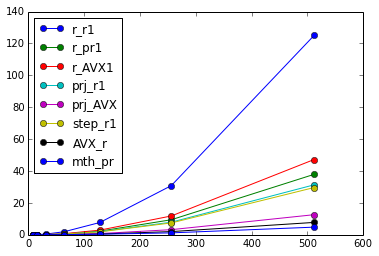

In [83]:
functions = [r_r1,r_pr1,r_AVX1,prj_r1,prj_AVX,step_r1,AVX_r,mth_pr]
for k in range(len(functions)):
    plt.plot(im_sizes,times[:][k], "o-", label = "{}".format(str(functions[k])[19:-1]))
plt.legend(loc="best")

**Discussion**

The result from this benchmark is actually not that exciting. We see the O($n^2$) complexity of the double for loop for the pixels. The ranking remains unchanged for the different methods.

The implementation r_r1 remains the slowest.

prj_r1 and step_r1 still have very similar performances.

mth_pr remains the best.

---

---

## **Benchmark when we vary the truncation parameter**

In [75]:
functions = [r_r1,r_pr1,r_AVX1,prj_r1,prj_AVX,step_r1,AVX_r,mth_pr]

th = [None,2,2,2,2,2,2,2]
iters = 11
truncates = [k for k in range(1,iters)]
sigma_r = 2
sigma_s = 2
im_size = 128

assert len(functions) == len(th)

times2 = [[0 for k in truncates] for fn in functions]


for k, fn in enumerate(functions):
    print str(fn)
    for l,truncate in enumerate(truncates):
        lw = (max(sigma_r, sigma_s)*truncate)

        #create picture
        picture = np.random.random((im_size, im_size))
        
        #preprocess
        imsize = np.shape(picture)
        input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
        input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')

        #time
        times2[k][l] = time_update(fn, truncate, imsize, picture, input_im, sigma_r, sigma_s, lw, th[k])
        
df2 = pd.DataFrame(times2, dtype = float)
df2.to_csv('times2.csv', index=False)

<built-in function r_r1>
<built-in function r_r1>: 1.00942111015s
<built-in function r_r1>: 2.71262311935s
<built-in function r_r1>: 4.28363919258s
<built-in function r_r1>: 7.67832303047s
<built-in function r_r1>: 10.2861511707s
<built-in function r_r1>: 15.4190070629s
<built-in function r_r1>: 18.9899201393s
<built-in function r_r1>: 25.7774009705s
<built-in function r_r1>: 30.3871181011s
<built-in function r_r1>: 39.8323748112s
<built-in function r_pr1>
<built-in function r_pr1>: 0.727787017822s
<built-in function r_pr1>: 1.25052905083s
<built-in function r_pr1>: 1.97246098518s
<built-in function r_pr1>: 2.81269001961s
<built-in function r_pr1>: 4.19944095612s
<built-in function r_pr1>: 5.64744305611s
<built-in function r_pr1>: 7.49790596962s
<built-in function r_pr1>: 9.45620512962s
<built-in function r_pr1>: 11.5738730431s
<built-in function r_pr1>: 11.4540829659s
<built-in function r_AVX1>
<built-in function r_AVX1>: 2.23056697845s
<built-in function r_AVX1>: 2.43670678139s
<buil

**Plot the results**

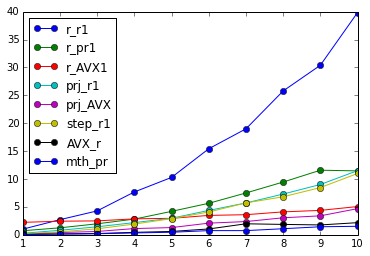

In [79]:
for k in range(len(functions)):
    plt.plot(truncates,times2[:][k],  "o-", label = "{}".format(str(functions[k])[19:-1]))
plt.legend(loc="best")

**Discussion**

We see that r_AVX1 becomes much better than r_r1 and r_pr1. Our assumption that this function was not performing well because the window  - needed to compute one output pixel - was too small and that overhead was hampering the performance seems to be correct.

The rest stays more or less the same. r_pr1 is sort of plateauing at a truncate number equals 10, but it is hard to tell with only one data point.

---

---

## **Benchmark when we vary the truncation parameter**

In [12]:
functions = [r_pr1,prj_r1,prj_AVX,step_r1,AVX_r,mth_pr]


iters = 8
threads = [k for k in range(1,iters)]
sigma_r = 2
sigma_s = 2
im_size = 128


times3 = [[0 for k in threads] for fn in functions]

truncate = 4
for k, fn in enumerate(functions):
    print str(fn)
    for l,thread in enumerate(threads):
        lw = (max(sigma_r, sigma_s)*truncate)

        th = [thread,thread,thread,thread,thread,thread]
        #create picture
        picture = np.random.random((im_size, im_size))
        
        #preprocess
        imsize = np.shape(picture)
        input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
        input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')

        #time
        times3[k][l] = time_update(fn, truncate, imsize, picture, input_im, sigma_r, sigma_s, lw, th[k])

        

<built-in function r_pr1>
<built-in function r_pr1>: 0.441732883453s
<built-in function r_pr1>: 0.377553939819s
<built-in function r_pr1>: 0.367692947388s
<built-in function r_pr1>: 0.372321128845s
<built-in function r_pr1>: 0.403692007065s
<built-in function r_pr1>: 0.428772211075s
<built-in function r_pr1>: 0.452977180481s
<built-in function prj_r1>
<built-in function prj_r1>: 0.369469165802s
<built-in function prj_r1>: 0.240805864334s
<built-in function prj_r1>: 0.202591896057s
<built-in function prj_r1>: 0.181882143021s
<built-in function prj_r1>: 0.195593118668s
<built-in function prj_r1>: 0.179741859436s
<built-in function prj_r1>: 0.167356014252s
<built-in function prj_AVX>
<built-in function prj_AVX>: 0.25238609314s
<built-in function prj_AVX>: 0.554149866104s
<built-in function prj_AVX>: 0.435288906097s
<built-in function prj_AVX>: 0.430124998093s
<built-in function prj_AVX>: 0.393033027649s
<built-in function prj_AVX>: 0.358952999115s
<built-in function prj_AVX>: 0.3398869037

In [13]:
df2 = pd.DataFrame(times3, dtype = float)
df2.to_csv('times3.csv', index=False)

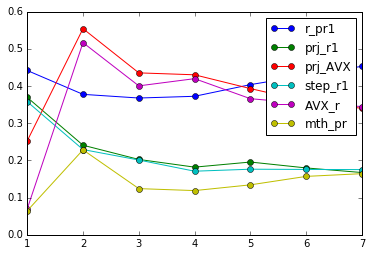

In [14]:
%matplotlib inline
for k in range(len(functions)):
    plt.plot(threads,times3[:][k],  "o-", label = "{}".format(str(functions[k])[19:-1]))
plt.legend(loc="best")

**Discussion**

NB: those results have been run on a machine with 8 physical threads.

We actually see that when we go from serial to 2 threads, the performance decrease for prj_AVX, AVX_t and mth_pr. The surprising result is that step_r1 and prj_r1 does not seem to have the same performence decrease whereas they have the same design. The only difference is that the 3 function that have a decrease in performence also use AVX. So we think that AVX+thread creates too much overhead to be profitable.

For AVX, performence start to re-increase but never get as good as with only one thread. We conclude from this that it is better to run either mutlithreaded code or AVX but not both for a small number of threads. This might be related to the hardware.

step_r1 and prj_r1 still have a very similar behavious which is consistent with the previous results. They get better as the number of threads increase. Though the marginal performance increase is diminishing with the number of threads, probably due to the overhead caused by a higer number of threads.

r_pr1 seem to reach an optimum with 3 threads after the overhead caused by a new thread decreases more the performence than the suplementary thread increases it. 


# 4. Gaussian filter

Here we implement most of the previously developped parallelized algorithm to the simple Gaussian filter. In this case the filtered image satisfies the convolution

$$ C_{i,j} = \sum_{m=0}^{2 l_w} \sum_{n=0}^{2 lw} K_{m,n} \, I_{i-lw + m, j-l_w+n},$$

where $C_{i,j}$ is the filtered image. $i$ and $j$ are the indices of the pixels in the image, K_{m,n} is the Gaussian Kernel and $I_{i,j}$ is the input image. The Gaussian kernel is defined as

$$ K_{m,n} = \frac{1}{\sqrt{2 \pi \sigma} }  \exp \left( \frac{||(m,n) - (i,j)||_2}{2 \sigma^2}  \right)$$

The purpose of this section is to compare our implementation to the scipy implementation.


Here is the class we developped that allows to apply a Gaussian filter with various implementation. We first take the image and pad it with various methods that are already implemented in scipy: reflect, nearest, constant and wrap. The description of all padding method is:


    mode       |   Ext   |         Input          |   Ext
    -----------+---------+------------------------+---------
    'reflect'  | 3  2  1 | 1  2  3  4  5  6  7  8 | 8  7  6 
    'nearest'  | 1  1  1 | 1  2  3  4  5  6  7  8 | 8  8  8
    'constant' | 0  0  0 | 1  2  3  4  5  6  7  8 | 0  0  0
    'wrap'     | 6  7  8 | 1  2  3  4  5  6  7  8 | 1  2  3  
    
In this case the kernel can be precomputed before defining the window. The kernel will be the same for every pixel -- this is different from the bilateral filter implementation. Here we have 4 different implementations. They all loop over $i$ and $j$ in serial. For each pixel, the window is assembled. The size of the window is [2* lw + 1, 2* lw + 1]. The convolution of the window with the kernel is implemented in 4 different ways:

1/ a simple python implementation of the convolution using numpy.sum(window*kernel) called by the method __filter_python__. 

2/ a cython implementation of the convolution using a "prange" for the loop over the rows called __filter_cython__. 

3/ an AVX implementation following the procedure shown in this figure.

In [16]:
from IPython.display import HTML 
HTML('<img src="./fig7.png" width=800 height=800/>') 

For each row, AVX loads 8 adjacent pixels of 32 bits of window and kernel. The middle column is not loaded. The loop over the rows in done using a __prange__. The method is called __filter_AVX__ 

4/ a multithreaded implementation. Each thread is takes care of one row of the input image. Thread 1 takes care of the first row, thread 2 takes care of the 2nd row, thread 3 of the 3r row, thread 4 of the 4th row and then thread 1 continues with row 5th etc (see figure below). The function is called __filter_cython_threading__.

In [17]:
HTML('<img src="./fig3.png" width=400 height=400/>') 

The code is shown in the cell below but won't run because of AVX implementation not supported in ipython notebook.

In [ ]:
'''
Here is the class Gaussianfilter2D

''' 
class Gaussianfilter2D():
    '''
    2D gaussian filter on Black and White images

    The filter image satisfies the relation
    $$ C_{i,j} = \sum_{m=0}^{2 l_w} \sum_{n=0}^{2 lw} = K_{m,n} \, I_{i-lw + m, j-l_w+n}$$
    where C is the new image, K the gaussian kernel and I the original image

    Parameters

    ----------

    sigma : float

        standard deviation for the gaussian filter

    truncate : float, optional

        truncate the filter at this many standard deviations
        Default is 4.0


    mode : here are the various mode supported by the class

    mode       |   Ext   |         Input          |   Ext
    -----------+---------+------------------------+---------
    'reflect'  | 3  2  1 | 1  2  3  4  5  6  7  8 | 8  7  6 
    'nearest'  | 1  1  1 | 1  2  3  4  5  6  7  8 | 8  8  8
    'constant' | 0  0  0 | 1  2  3  4  5  6  7  8 | 0  0  0
    'wrap'     | 6  7  8 | 1  2  3  4  5  6  7  8 | 1  2  3    


    Attributes

    ----------   

    kernel_ : 2d-array

        this is the 2D gaussian filter kernel used in the convolution
        with the provided image

    image_benchmark_: 2d-array

        this is the image filtered with the 2D gaussian filter provided
        by the scipy library

    run_time_benchmark_: float

        this is the run time of the 2D gaussian filter provied by the
        scipy library

    image_: 2d-array

        this is the image filtered by the 2D gaussian filter implemented in 
        python

    run_time_: float

        this is the run time of the 2D gaussian filter implemented in python

    error_ : float

        this is the norm-2 error of the python function compared with the scipy
        function

    '''
    def __init__(self, sigma, truncate = 4.0 , mode = 'reflect', cval = 0.0,
                    num_threads = 4):


        self.sigma = sigma
        self.truncate = truncate
        self.mode = mode
        self.cval = cval
        self.num_threads = num_threads


        # lw is the number of adjacent pixels on both sides to consider in 1D
        # when using the filter 
        self.lw = int(truncate*sigma+0.5)   


    @property
    # this is read only
    def kernel_(self):

        '''
        this function generates the Gaussianfilter2D kernel
        '''

        # initialize the size of the gaussian kernel
        # kernel size: pan * pan (33 * 33 when truncate = 4.0 and sigma = 4.0)
        self._kernel = np.zeros((2 * self.lw + 1,2 * self.lw +1 ))

        # find the distance to the center of all pixels in the kernel
        for i in range(0,self.lw+1):
            for j in range(0,self.lw+1):
                # pixel at the center the distance is 0
                if i == 0 and j ==0:
                    self._kernel[self.lw,self.lw] = 0
                # the other pixels in the kernel
                else:
                    self._kernel[i+self.lw,j+self.lw] = np.linalg.norm([i,j])**2
                    self._kernel[-i+self.lw,-j+self.lw] = np.linalg.norm([i,j])**2
                    self._kernel[-i+self.lw,j+self.lw] = np.linalg.norm([i,j])**2
                    self._kernel[i+self.lw,-j+self.lw] = np.linalg.norm([i,j])**2
                
        # compute the gaussian kernel
        self._kernel *= -.5/self.sigma**2
        self._kernel = np.exp(self._kernel)
        self._kernel /= 2*np.pi * self.sigma**2
        self._kernel /= np.sum(self._kernel)

        return self._kernel

    def filter_scipy(self, f ):
        start = time.time()
        self.image_benchmark_ = gaussian_filter(f,self.sigma , mode = self.mode, cval = self.cval )
        self.run_time_benchmark_ = time.time() - start
        return self.image_benchmark_, self.run_time_benchmark_

    def _python_convolution(self, lx, ly, image):

        # convolution with the gaussian kernel for filtering
        for i in range(0 , lx ):
            for j in range(0 , ly ):
                window = image[i : i + 2*self.lw + 1, j: j + 2*self.lw + 1]
                self.image_[i , j]= np.sum(window*self._kernel)
        return self.image_

    def _return_cython_convolution(self, lx, ly, image):

        # convolution using the Gaussian kernel

        # initialize for cython
        image_in = np.array(image, dtype = np.float32)
        image_out = np.zeros((lx,ly), dtype = np.float32)
        kernel = np.array(self._kernel, dtype = np.float32)
        _cython_convolution(self.lw, lx, ly, image_in, image_out, kernel, self.num_threads)

        self.image_ = image_out

        return self.image_  

        
    def _return_AVX_cython_convolution(self, lx, ly, image):

        # convolution using the Gaussian kernel

        # initialize for cython
        image_in = np.array(image, dtype = np.float32)
        image_out = np.zeros((lx,ly), dtype = np.float32)
        kernel = np.array(self._kernel, dtype = np.float32)
        _AVX_cython_convolution(self.lw, lx, ly, image_in, image_out, kernel, self.num_threads)

        self.image_ = image_out

        return self.image_

    def filter_AVX(self,f):


        start = time.time()
        self.image_ = f * 0.0
        lx, ly = f.shape
        # create the gaussian filter kernel
        self._kernel = self.kernel_

        # implement the different type of method to treat the edges
        image = self._padding(f)

        # convolution with the gaussian kernel for filtering
        self.image_= self._return_AVX_cython_convolution(lx,ly,image)

        self.run_time_ = time.time() - start

        # run the filter with scipy to get error and run time difference
        self.filter_scipy(f)
        self.error_ = np.linalg.norm(self.image_benchmark_-self.image_)

        # run time is normalized by the run time of the scipy library
        self.run_time_ /= self.run_time_benchmark_

        return self     

    def filter_cython(self,f):


        start = time.time()
        self.image_ = f * 0.0
        lx, ly = f.shape
        # create the gaussian filter kernel
        self._kernel = self.kernel_

        # implement the different type of method to treat the edges
        image = self._padding(f)

        # convolution with the gaussian kernel for filtering
        self.image_= self._return_cython_convolution(lx,ly,image)

        self.run_time_ = time.time() - start

        # run the filter with scipy to get error and run time difference
        self.filter_scipy(f)
        self.error_ = np.linalg.norm(self.image_benchmark_-self.image_)

        # run time is normalized by the run time of the scipy library
        self.run_time_ /= self.run_time_benchmark_

        return self 

    def filter_python(self,f):


        start = time.time()
        self.image_ = f * 0.0
        lx, ly = f.shape
        # create the gaussian filter kernel
        self._kernel = self.kernel_

        # implement the different type of method to treat the edges
        image = self._padding(f)

        # convolution with the gaussian kernel for filtering
        self.image_= self._python_convolution(lx,ly,image)

        self.run_time_ = time.time() - start

        # run the filter with scipy to get error and run time difference
        self.filter_scipy(f)
        self.error_ = np.linalg.norm(self.image_benchmark_-self.image_)

        # run time is normalized by the run time of the scipy library
        self.run_time_ /= self.run_time_benchmark_

        return self

    def _padding(self, f):
        
        # implement the different type of method to treat the edges

        if self.mode == 'constant':

            # padding using the scipy library
            image = np.lib.pad(f , self.lw, 'constant', constant_values = self.cval)    

        elif self.mode == 'reflect':

            # padding using the scipy library
            image = np.lib.pad(f , self.lw, 'reflect')


        elif self.mode == 'wrap':

            # padding using the scipy library
            image = np.lib.pad(f , self.lw, 'wrap')

        elif self.mode == 'nearest':    

            # padding using the scipy library
            image = np.lib.pad(f , self.lw, 'edge')

        return image



def filter_cython_threading(gb, f):

    start = time.time()
    gb.image_ = f * 0.0
    lx, ly = f.shape
    # create the gaussian filter kernel
    gb._kernel = gb.kernel_

    # implement the different type of method to treat the edges
    image = gb._padding(f)

    # convolution with the gaussian kernel for filtering
    gb.image_= _return_cython_convolution_threading(gb.lw,lx,ly,image,gb._kernel,gb.num_threads)

    gb.run_time_ = time.time() - start

    # run the filter with scipy to get error and run time difference
    gb.filter_scipy(f)
    gb.error_ = np.linalg.norm(gb.image_benchmark_-gb.image_)

    # run time is normalized by the run time of the scipy library
    gb.run_time_ /= gb.run_time_benchmark_

    return gb   

def _return_cython_convolution_threading(lw,lx, ly, image,kernel,num_threads):

    # convolution using the Gaussian kernel

    # initialize for cython
    image_in = np.array(image, dtype = np.float32)
    image_out = np.zeros((lx,ly), dtype = np.float32)
    kernel = np.array(kernel, dtype = np.float32)

    # # Create a list of threads
    threads = []
    for thread_id in range(num_threads):
        # t = threading.Thread(target = filter_threading, args = (image_out,thread_id))
        t = threading.Thread(target = filter_threading,
                            args = (lw, lx, ly, image_in, image_out, kernel, 
                                    thread_id,num_threads))
        threads.append(t)
        t.start()
    # make sure all the threads are done
    [t.join() for t in threads]

    return image_out        

def filter_threading(lw, lx, ly, image_in,image_out,kernel,thread_id, num_threads):
    # print('thread_id {}: image_out before= {} '.format(thread_id,image_out[0,0]))
    assert np.all(image_out[thread_id,:] == 0)
    _cython_convolution_threading(lw, lx, ly, image_in,image_out,kernel,thread_id, num_threads)
    # print('thread_id {}: image_in after= {} , image_out after= {} '
    #   .format(thread_id,image_in[thread_id+ num_threads,-8::],image_out[thread_id+ num_threads,-8::]))
    return image_out 

'''
These are the cython functions called by the class Gaussianfilter2D

'''


# cython decorators
@cython.boundscheck(False)
@cython.wraparound(False)

cpdef _AVX_cython_convolution(int lw,
                                int lx,
                                int ly,
                                np.float32_t [:,:] image_in,
                                np.float32_t [:,:] image_out,
                                np.float32_t [:,:] kernel,
                                int num_threads ):
    '''
    this function does the convolution for the Gaussian filter in 2D
    the function is written in cython for paralellizing the loops and 
    also uses AVX for the convolution. 

    Parameters

    ----------

    lw : int 

        number of adjacent pixels to considers on each sides 
        of the pixel that is being filtered

    lx, ly : int, int

        size of the image (lx, ly)

    image_in, image_out: np.float32_t

        the input image to be filtered and the resulting image filtered

    kernel: np.float32_t

        the 2D Gaussian kernel used for convolution

    num_threads: int

        the number of threads used for paralellization

    '''

    cdef:
        int i,j, i_local, k, m_8, n_elem, ii, jj
        np.float32_t [:,:] window
        np.float32_t [:] output_array_left,output_array_right, \
                            output_array_top, output_array_bot
        AVX.float8 AVX_coef_left, kernel_AVX_left, window_AVX_left, \
                            AVX_coef_right, kernel_AVX_right, window_AVX_right,\
                            AVX_coef_top, kernel_AVX_top , window_AVX_top, \
                            AVX_coef_bot, kernel_AVX_bot, window_AVX_bot
        float sumg , check_sum_manual
        int j_m

    # Find the modulus of the number of adjacent pixels 
    # note we assume that lw % 8 = 0 in this version of the code
    n_elem = lw / 8

    # loop over i and j to filter all the pixels
    window = np.zeros((2 * lw + 1, 2 * lw + 1), dtype = np.float32)
    for i in range(lx):
    # for i in prange(lx, \
    #           nogil=True, schedule = 'static', chunksize =1, num_threads= num_threads):   
        for j in range(ly):
        # for j in prange(ly, \
        #           nogil=True, schedule = 'static', chunksize =1, num_threads= num_threads):   

            # For one pixel, we proceed here to the convolution
            # i.e. np.sum(kernel * window)          

            # initialize summation 
            sumg = 0.0

            # define the image window used for the convolution with the kernel
            # for ii in range(2*lw +1):
            #   for jj in range(2 *lw +1):
            #       window[ii,jj] = image_in[i + ii,j + jj]

            window = image_in[i : i + 2*lw + 1, j: j + 2*lw + 1]

            # Doing the convolution with a first loop on the rows
            # We use AVX 8 float vectors to loop over the columns
            # i.e. multiplication and addition of 8 adjacent columns of 
            # kernel and window at a time

            # for i_local in range(window.shape[0]):
            for i_local in prange(window.shape[0], \
                nogil=True, schedule = 'static', chunksize =1, num_threads= num_threads):   
                for m_8 in range(n_elem):


                    # The pixel in the middle is at (i_local,lw)
                    # here we sum the left part
                    window_AVX_left = AVX.make_float8(window[i_local,m_8*8+7],
                                                     window[i_local,m_8*8+ 6],
                                                     window[i_local,m_8*8+ 5],
                                                     window[i_local,m_8*8+ 4],
                                                     window[i_local,m_8*8+ 3],
                                                     window[i_local,m_8*8+ 2],
                                                     window[i_local,m_8*8+ 1],
                                                     window[i_local,m_8*8+ 0])
                    kernel_AVX_left =  AVX.make_float8(kernel[i_local,m_8*8+7],
                                             kernel[i_local,m_8*8+6],
                                             kernel[i_local,m_8*8+5],
                                             kernel[i_local,m_8*8+4],
                                             kernel[i_local,m_8*8+3],
                                             kernel[i_local,m_8*8+2],
                                             kernel[i_local,m_8*8+1],
                                             kernel[i_local,m_8*8+0])
                    AVX_coef_left = AVX.mul(window_AVX_left,kernel_AVX_left)

                    # right part
                    window_AVX_right = AVX.make_float8(window[i_local,lw+1+m_8*8+ 7],
                                                     window[i_local, lw+1+ m_8*8+6],
                                                     window[i_local, lw+1+ m_8*8+5],
                                                     window[i_local, lw+1+ m_8*8+4],
                                                     window[i_local, lw+1+ m_8*8+3],
                                                     window[i_local, lw+1+ m_8*8+2],
                                                     window[i_local, lw+1+ m_8*8+1],
                                                     window[i_local,lw+1+  m_8*8+0])
                    kernel_AVX_right =  AVX.make_float8(kernel[i_local,lw+1+m_8*8+7],
                                             kernel[i_local,lw+1+m_8*8+6],
                                             kernel[i_local,lw+1+m_8*8+5],
                                             kernel[i_local,lw+1+m_8*8+4],
                                             kernel[i_local,lw+1+m_8*8+3],
                                             kernel[i_local,lw+1+m_8*8+2],
                                             kernel[i_local,lw+1+m_8*8+1],
                                             kernel[i_local,lw+1+m_8*8+0])
                    AVX_coef_right = AVX.mul(window_AVX_right,kernel_AVX_right) 

                    # summation of the 8 floats in AVX
                    for k in range(8):
                        sumg += <np.float32_t> (<np.float32_t *> &AVX_coef_left)[k]
                        sumg += <np.float32_t> (<np.float32_t *> &AVX_coef_right)[k]
                

            # Now we consider the column in the middle (:, lw)
            # we can multipliate and add after storing into AVX vectors
            # top and bottom
            window_AVX_top = AVX.make_float8(window[m_8*8+ 7, lw],
                                             window[ m_8*8+6, lw],
                                             window[ m_8*8+5, lw],
                                             window[ m_8*8+4, lw],
                                             window[ m_8*8+3, lw],
                                             window[ m_8*8+2, lw],
                                             window[ m_8*8+1, lw],
                                             window[ m_8*8+0, lw])
            kernel_AVX_top =  AVX.make_float8(kernel[m_8*8+7, lw],
                                     kernel[m_8*8+6, lw],
                                     kernel[m_8*8+5, lw],
                                     kernel[m_8*8+4, lw],
                                     kernel[m_8*8+3, lw],
                                     kernel[m_8*8+2, lw],
                                     kernel[m_8*8+1, lw],
                                     kernel[m_8*8+0, lw])
            AVX_coef_top = AVX.mul(window_AVX_top,kernel_AVX_top)   

            window_AVX_bot = AVX.make_float8(window[lw+1+ m_8*8+7, lw],
                                             window[ lw+1+ m_8*8+6, lw],
                                             window[ lw+1+ m_8*8+5, lw],
                                             window[ lw+1+ m_8*8+4, lw],
                                             window[ lw+1+ m_8*8+3, lw],
                                             window[ lw+1+ m_8*8+2, lw],
                                             window[ lw+1+ m_8*8+1, lw],
                                             window[lw+1+  m_8*8+0, lw])
            kernel_AVX_bot =  AVX.make_float8(kernel[lw+1+m_8*8+7, lw],
                                     kernel[lw+1+m_8*8+6, lw],
                                     kernel[lw+1+m_8*8+5, lw],
                                     kernel[lw+1+m_8*8+4, lw],
                                     kernel[lw+1+m_8*8+3, lw],
                                     kernel[lw+1+m_8*8+2, lw],
                                     kernel[lw+1+m_8*8+1, lw],
                                     kernel[lw+1+ m_8*8+0, lw])
            AVX_coef_bot = AVX.mul(window_AVX_bot,kernel_AVX_bot)


            for k in range(8):
                sumg += <np.float32_t> (<np.float32_t *> &AVX_coef_top)[k]
                sumg += <np.float32_t> (<np.float32_t *> &AVX_coef_bot)[k]

            # add the middle one
            sumg += kernel[lw,lw]*window[lw,lw]                                     

            # compute the filtered image
            image_out[i, j] = sumg

# cython decorators
@cython.boundscheck(False)
@cython.wraparound(False)

cdef _cython_convolution(int lw,
                        int  lx,
                        int  ly,
                        np.float32_t [:,:] image_in,
                        np.float32_t [:,:] image_out,
                        np.float32_t [:,:] kernel,
                        int num_threads):

    cdef:
        int i, j, i_local, j_local
        np.float32_t [:,:] window
        float sumg

    # convolution with the gaussian kernel for filtering
    for i in range(0 , lx ):
        for j in range(0 , ly ):
            window = image_in[i : i + 2* lw + 1, j: j + 2* lw + 1]
            sumg = 0.0
            # for i_local in range(window.shape[0]):
            for i_local in prange(window.shape[0], \
                nogil=True, schedule = 'static', num_threads= num_threads):
                for j_local in range(window.shape[1]):
                    sumg += window[i_local, j_local]*kernel[i_local,j_local]
            image_out[i, j] = sumg
            
@cython.boundscheck(False)
@cython.wraparound(False)
cdef filter_threading_2(np.float32_t [:,:] image_out,int thread_id):
    image_out[0,0] += 1

# cython decorators
@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cython_convolution_threading(int lw,
                        int  lx,
                        int  ly,
                        np.float32_t [:,:] image_in,
                        np.float32_t [:,:] image_out,
                        np.float32_t [:,:] kernel,
                        int offset,
                        unsigned int step):
    cdef:
        int i, j, i_local, j_local
        np.float32_t [:,:] window
        float sumg

    # # convolution with the gaussian kernel for filtering
    with nogil:
        i = offset
        while i < lx :
            for j in range(0, ly):
                window = image_in[i : i +2* lw+ 1, j: j + 2* lw + 1]
                sumg = 0.0
                for i_local in range(window.shape[0]):
                    for j_local in range(window.shape[1]):
                        sumg += window[i_local, j_local]*kernel[i_local,j_local]
                image_out[i, j] = sumg
            i += step

In [18]:
# ------------------------------------------------------------
# import modules to compile cython and AVX
# ------------------------------------------------------------
%matplotlib inline
import sys
import os.path
sys.path.append(os.path.join('.', 'util'))

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()
import pdb


from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
from Gaussianfilter2D_class import Gaussianfilter2D, filter_cython_threading

# --------------------------------------------
# initialization - define image
# --------------------------------------------*
imagename = 'test.png'

# load image (only one color now)
f = misc.imread(imagename)
if imagename == 'small.png':
    f = f[:,:,0]
else:
    pass


# --------------------------------------------
# Gaussian filter
# --------------------------------------------

# create a instance gaussian filter
gb = Gaussianfilter2D(sigma = 8.0, truncate = 8.0, mode = 'reflect', cval = 0.0, num_threads = 8)


# --------------------------------------------
# print the run times
# --------------------------------------------

gb.filter_python(f)
print('run time python = {} * run time scipy'.format(gb.run_time_))

gb.filter_cython(f)
print('run time cython = {} * run time scipy'.format(gb.run_time_))

gb.filter_AVX(f)
print('run time AVX = {} * run time scipy'.format(gb.run_time_))

filter_cython_threading(gb,f)
print('run time cython with multithreading = {} * run time scipy'.format(gb.run_time_))



Compiling with /usr/local/bin/clang-omp
run time python = 600.195764355 * run time scipy
run time cython = 140.950568026 * run time scipy
run time AVX = 150.628835194 * run time scipy
run time cython with multithreading = 83.3375489724 * run time scipy


We find that in the case of a small window the cython mutlithtreading is the most efficient method. Let us compare the run time for various values of truncate and number of threads. First we show our computer hardware

In [19]:
%load_ext watermark
%watermark

2016-02-05T21:49:29

CPython 2.7.11
IPython 4.0.3

compiler   : GCC 4.2.1 (Apple Inc. build 5577)
system     : Darwin
release    : 15.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [21]:
time_python = []
time_cython = []
time_AVX = []
time_threading = []

truncate_vector = [4,8,12,16,20]
threads = [4,8]
for t in threads:
    for trunc in truncate_vector:
        # create a instance gaussian filter
        gb = Gaussianfilter2D(sigma = 8.0, truncate = trunc, mode = 'reflect', cval = 0.0, num_threads = t)
        gb.filter_python(f)
        time_python.append(gb.run_time_)
        gb.filter_cython(f)
        time_cython.append(gb.run_time_)
        gb.filter_AVX(f)
        time_AVX.append(gb.run_time_)
        filter_cython_threading(gb,f)
        time_threading.append(gb.run_time_)

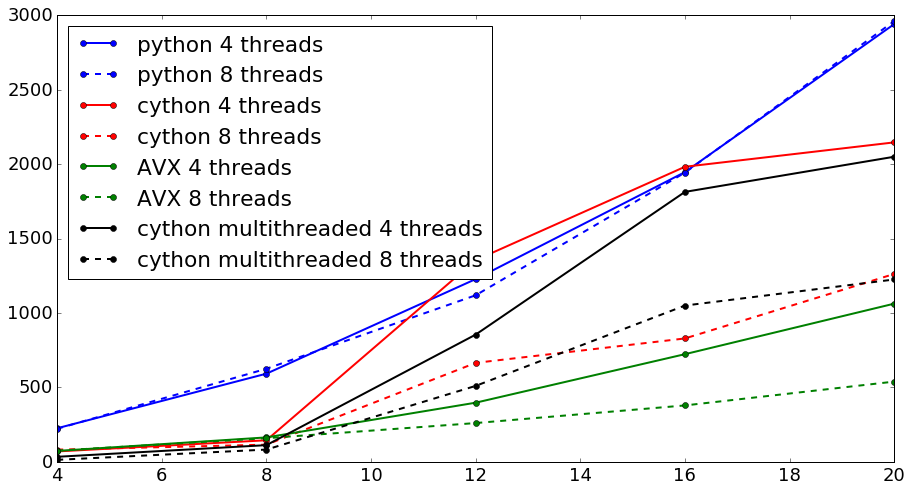

In [22]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15,8))
plt.plot(truncate_vector,time_python[0:5], 'bo-',lw =2,label ='python 4 threads')
plt.plot(truncate_vector,time_python[5::], 'bo--',lw =2,label ='python 8 threads')
plt.plot(truncate_vector,time_cython[0:5], 'ro-',lw =2,label='cython 4 threads')
plt.plot(truncate_vector,time_cython[5::], 'ro--',lw =2,label='cython 8 threads')
plt.plot(truncate_vector, time_AVX[0:5], 'go-',lw =2,label ='AVX 4 threads')
plt.plot(truncate_vector, time_AVX[5::], 'go--',lw =2,label ='AVX 8 threads')
plt.plot(truncate_vector,time_threading[0:5], 'ko-',lw =2,label='cython multithreaded 4 threads')
plt.plot(truncate_vector,time_threading[5::], 'ko--',lw =2,label='cython multithreaded 8 threads')
plt.legend(loc='best')

## 4.1 Analysis

As expected the python implementation is the slowest. The cython implementation has a prange over the rows of the window. For larger values of the window's size we see a good speed up with the increasing number of threads -- there is no overhead anymore. For a small window the AVX implementation is not faster than the cython implementation. It is because there are not many float8 (vectors of 8 float_32t) to load and use for the convolution. The serial version of the sum and multiplication over the columns is as fast as the AVX implementation. However when the number of columns in the window becomes big enoug (truncate = 16 for example), we can load multiple float8 and it is faster than the serial version. The cython multithreading version is faster than AVX when the size of the window is relatively small. It is because the convolution is relatively fast to do, and therefore distributing the pixels of the input image is a fast algorithm. However for a large window, the most efficient way is still to speed up the convolution with AVX.

# Conclusion

The main take-aways of our study are:

- AVX can be useful for both computing output pixels and computing contributions of a context window for one pixel. However, for the latter to be efficient, you need a truncate number big enough. Otherwise the increase in performance is nullified by overhead.
- It is useful to use either AVX or prange but the combination of both does not give better performance (for a number of threads inferior to 8)
- Our best implementation for the bilateral filter uses mutlithread and AVX to compute output pixels.
- Our best implementation for the gaussian filter uses AVX to compute contribution of context to one output pixel.


Ways forward would be:

- Implementing the exp function in AVX
- Rewrite the code where AVX is used to compute output pixels in a more flexible way (using mask as we did for the AVX implementation of a pixel computation).
- Not in the same spirit as this report, we think that implementing the filters on integrated GPU would be the best.